In [5]:
# To begin using librosa we need to import it, and other tools such as matplotlib and numpy
from __future__ import print_function # use the print() function from Python3
from operator import add
from pylab import *
import librosa             # The librosa library
import librosa.display     # librosa's display module (for plotting features)
import IPython.display     # IPython's display module (for in-line audio)
import matplotlib.pyplot as plt # matplotlib plotting functions
import matplotlib.style as ms   # plotting style
import numpy as np              # numpy numerical functions
ms.use('seaborn-muted')         # fancy plot designs
import soundfile as sf
from numpy import random
from scipy import signal
import matplotlib.pyplot as plt
from statistics import mean 
import librosa
import scipy.io.wavfile as wavf
import pandas as pd
from tree_lib import *

In [147]:
df = pd.read_csv("ratings.csv")

In [148]:
df.describe()

,IDX,cont_rating
count,1000.000000,1000.000000
mean,499.500000,22.344000
std,288.819436,19.782897
min,0.000000,0.000000
25%,249.750000,10.000000
50%,499.500000,15.000000
75%,749.250000,30.000000
max,999.000000,100.000000


In [39]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,IDX,cont_rating
IDX,1,-0.162631
cont_rating,-0.162631,1


In [149]:
df.head()

,IDX,expression,cont_rating
0,0,(t^(t|11))^((t*12)&11),0
1,1,t*(t/10),5
2,2,(t|(t&7))*(t/8),5
3,3,((t>>6)-(t^((t>>1)|5)))-((t>>4)&5),10
4,4,(t*((3+(1^((t>>10)&5)))*(5+(3&(t>>14)))))>>((t...,80


In [150]:
expressions = df["expression"]
#render_tups = render(expressions, 8000, 30)
#renderings = render_tups[0]

In [100]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_renderings = []
for test in renderings:
    test_arr = np.array(test)
    test_arr = np.array([test_arr])
    test_trans = scaler.fit_transform(test_arr.T)
    normalized_renderings.append(test_trans.T[0])
    

In [103]:
'''
with open('normalized_renderings.csv', 'w') as f:
    for item in normalized_renderings:
        f.write("%s\n" % list(item))

f.close()

'''




In [152]:
IPython.display.Audio(normalized_renderings[378], rate=8000)

't*(t/10)'

In [159]:
expression_testing = []
for i in range(len(expressions)):
    print(i)
    y = np.array(normalized_renderings[i], dtype = 'f')
    sr = 8000
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    o_env = librosa.onset.onset_strength(y, sr=sr)
    times = librosa.times_like(o_env, sr=sr)
    intervals = [times[0]]
    for i in range(1,len(times)):
        intervals.append(times[i] - times[i-1])
        

    z_cross = librosa.feature.zero_crossing_rate(y=y)
    avg_zcross = z_cross.mean()
    std_zcross = np.std(z_cross)
    
    flatness = librosa.feature.spectral_flatness(y=y)
    avg_flt = flatness.mean()
    std_flt = np.std(flatness)
    
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    avg_bw = spec_bw.mean()
    
    spec_ctr = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=4)
    avg_ctr = spec_ctr.mean()
    std_ctr = np.std(spec_ctr)
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    avg_cent = cent.mean()
    std_cent = np.std(cent)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    avg_rolloff = rolloff.mean()
    std_rolloff = np.std(rolloff)
    
    expression_testing.append([tempo, avg_cent, std_cent, avg_rolloff, std_rolloff, avg_zcross, std_zcross, avg_flt, std_flt, avg_bw, avg_ctr, std_ctr])
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [111]:
#expression_testing = expression_testing[1:]

In [160]:
df = pd.DataFrame(expression_testing, columns = ['tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr'])
df2 = pd.read_csv("ratings.csv")
df["rating"] = df2["cont_rating"]
df["expression"] = df2["expression"]

In [161]:
df

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,rating,expression
0,0.000000,2397.742187,15.091598,3499.092151,18.751655,0.623013,0.018510,0.000018,0.000256,849.466258,69.718268,38.167484,0,(t^(t|11))^((t*12)&11)
1,0.000000,1967.835677,139.002189,3359.908049,107.338253,0.498658,0.056105,0.405539,0.063400,1169.781651,16.963792,2.828404,5,t*(t/10)
2,0.000000,1973.796906,123.739123,3380.505397,84.243555,0.498456,0.015501,0.297074,0.010253,1174.761842,23.286908,5.089016,5,(t|(t&7))*(t/8)
3,0.000000,1090.473150,82.708608,2546.341951,161.222079,0.030035,0.003914,0.064719,0.013866,1119.578280,17.700608,5.406530,10,((t>>6)-(t^((t>>1)|5)))-((t>>4)&5)
4,0.000000,1375.247172,125.774728,2883.745336,125.740284,0.127081,0.045806,0.094418,0.018604,1145.171747,19.485216,3.035491,80,(t*((3+(1^((t>>10)&5)))*(5+(3&(t>>14)))))>>((t...
5,58.593750,1405.434159,318.545960,2943.813300,549.612072,0.210597,0.125716,0.014998,0.014760,1211.328055,37.113671,25.308378,45,t>>((t^(t|11))*(((t|8)&(((t>>10)*(t&11))*10))>...
6,14.648438,142.246772,125.576124,64.690498,310.284654,0.000122,0.000870,0.000069,0.000798,517.264980,46.739396,34.808292,10,((t>>13)>>(t&(t&(t>>15))))|(t>>(t*(t>>12)))
7,14.648438,1643.016174,79.731008,3641.749400,70.769139,0.279184,0.031679,0.000308,0.001480,1512.211990,71.984035,15.198755,10,(t|9)>>((t&9)*7)
8,15.120968,1442.582115,280.605665,2862.548308,287.227102,0.120822,0.062164,0.054682,0.058273,1092.622997,52.876133,34.281462,90,t*(((t>>6)&12)|(((t>>12)&25)^(((t>>10)&12)&(t>...
9,17.045455,2069.834397,107.679454,3613.347881,138.731292,0.513928,0.015297,0.018100,0.018540,1157.059127,22.660011,6.563790,5,(((t|5)*7)>>8)^((t*6)*11)


In [162]:
df.describe()

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,107.475174,1317.554964,194.716700,2734.677047,318.999859,0.187951,0.067569,0.035749,0.015463,1165.561943,26.309811,10.407424,22.344000
std,55.341289,454.115297,120.529533,701.538060,242.829092,0.173898,0.076038,0.068494,0.024824,159.825001,11.625823,8.403179,19.782897
min,0.000000,81.947177,5.276370,64.690498,0.180181,0.000003,0.000000,0.000012,0.000068,310.285874,6.365315,1.807366,0.000000
25%,58.593750,960.694942,106.153711,2265.791578,148.987617,0.025881,0.008543,0.002556,0.002614,1049.016733,19.321484,5.209481,10.000000
50%,117.187500,1355.208617,163.167806,2923.303405,257.853018,0.133215,0.040105,0.009213,0.006057,1172.426313,23.117225,6.919296,15.000000
75%,117.187500,1670.299295,256.248571,3271.361524,432.398541,0.292770,0.104854,0.032037,0.015748,1265.650580,28.699845,11.147264,30.000000
max,312.500000,3185.330203,833.474729,3999.383662,1454.644576,0.989808,0.476764,0.527401,0.227963,1812.080265,99.209843,38.805646,100.000000


In [163]:

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,rating
tempo,1,-0.154943,0.0319906,-0.12572,0.128588,-0.136103,-0.101615,-0.0733331,-0.0638587,-0.0380664,-0.0200012,-0.0293729,0.0441757
avg_cent,-0.154943,1,0.0992715,0.933313,-0.346741,0.876275,0.496006,0.42228,0.368693,0.687213,-0.0073753,-0.0777166,0.0187324
std_cent,0.0319906,0.0992715,1,0.0668535,0.759427,0.161578,0.722088,-0.0165592,0.0882293,0.0198781,0.0787752,0.20158,0.330144
avg_rolloff,-0.12572,0.933313,0.0668535,1,-0.338707,0.730782,0.409429,0.332845,0.31217,0.860939,-0.00103031,-0.093876,-0.0112216
std_rolloff,0.128588,-0.346741,0.759427,-0.338707,1,-0.205163,0.276805,-0.218385,-0.123041,-0.260301,0.114903,0.236835,0.253739
avg_zcross,-0.136103,0.876275,0.161578,0.730782,-0.205163,1,0.56708,0.383697,0.284318,0.475173,-0.00685699,-0.0163799,0.00360718
std_zcross,-0.101615,0.496006,0.722088,0.409429,0.276805,0.56708,1,0.218644,0.285604,0.248421,0.00320195,0.043057,0.233578
avg_flt,-0.0733331,0.42228,-0.0165592,0.332845,-0.218385,0.383697,0.218644,1,0.735266,0.118301,-0.317891,-0.296883,-0.0203942
std_flt,-0.0638587,0.368693,0.0882293,0.31217,-0.123041,0.284318,0.285604,0.735266,1,0.139993,-0.204228,-0.152919,0.113816
avg_bw,-0.0380664,0.687213,0.0198781,0.860939,-0.260301,0.475173,0.248421,0.118301,0.139993,1,-0.0148839,-0.13145,-0.0840605


In [165]:
df.describe()
df.to_csv("Spectral_Features.csv")

In [169]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,rating
tempo,1,-0.154943,0.0319906,-0.12572,0.128588,-0.136103,-0.101615,-0.0733331,-0.0638587,-0.0380664,-0.0200012,-0.0293729,0.0441757
avg_cent,-0.154943,1,0.0992715,0.933313,-0.346741,0.876275,0.496006,0.42228,0.368693,0.687213,-0.0073753,-0.0777166,0.0187324
std_cent,0.0319906,0.0992715,1,0.0668535,0.759427,0.161578,0.722088,-0.0165592,0.0882293,0.0198781,0.0787752,0.20158,0.330144
avg_rolloff,-0.12572,0.933313,0.0668535,1,-0.338707,0.730782,0.409429,0.332845,0.31217,0.860939,-0.00103031,-0.093876,-0.0112216
std_rolloff,0.128588,-0.346741,0.759427,-0.338707,1,-0.205163,0.276805,-0.218385,-0.123041,-0.260301,0.114903,0.236835,0.253739
avg_zcross,-0.136103,0.876275,0.161578,0.730782,-0.205163,1,0.56708,0.383697,0.284318,0.475173,-0.00685699,-0.0163799,0.00360718
std_zcross,-0.101615,0.496006,0.722088,0.409429,0.276805,0.56708,1,0.218644,0.285604,0.248421,0.00320195,0.043057,0.233578
avg_flt,-0.0733331,0.42228,-0.0165592,0.332845,-0.218385,0.383697,0.218644,1,0.735266,0.118301,-0.317891,-0.296883,-0.0203942
std_flt,-0.0638587,0.368693,0.0882293,0.31217,-0.123041,0.284318,0.285604,0.735266,1,0.139993,-0.204228,-0.152919,0.113816
avg_bw,-0.0380664,0.687213,0.0198781,0.860939,-0.260301,0.475173,0.248421,0.118301,0.139993,1,-0.0148839,-0.13145,-0.0840605


In [170]:
from sklearn import preprocessing



In [250]:
df2 = pd.read_csv("backups/spectral_data2.csv")
X = df[['tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr']]
y = df["rating"]

In [251]:
#X = df2[["std_cent", "std_rolloff", "std_zcross", "std_flt", "avg_bw", "avg_ctr", "std_ctr"]]
#y = df2["cont_rating"]

In [252]:
import torch

dtype = torch.float
device = torch.device("cpu")

N, D_in, H, D_out = 1000, 12, 10, 1 #4

train_size = 800
test_size = N - train_size

x = torch.from_numpy(np.array(X, dtype = 'f')).float()
y = torch.from_numpy(np.expand_dims(np.array(y, dtype = 'f'),axis=1)).float()


In [253]:
print(y.size())
print(x.size())
print(train_size)
print(test_size)

torch.Size([1000, 1])
torch.Size([1000, 12])
800
200


In [254]:
hidden = 6
for H in range(hidden, hidden+1):
    N, D_in, H1, D_out = 1000, 12, H, 1 #4
    t_loss = []
    v_loss = []
    for i in range(1):
        loss_dic = {'train': [], 'validation': []}
        train_dataset, test_dataset = torch.utils.data.random_split(torch.cat((x, y), 1), [train_size, test_size])
        X_train = train_dataset.dataset[train_dataset.indices][:, :D_in]
        X_test = test_dataset.dataset[test_dataset.indices][:, :D_in]
        y_train = train_dataset.dataset[train_dataset.indices][:, D_in: D_in + D_out]
        y_test = test_dataset.dataset[test_dataset.indices][:, D_in:D_in + D_out]

        scaler = preprocessing.StandardScaler()
        X_train = torch.from_numpy(scaler.fit_transform(X_train.numpy()))
        X_test = torch.from_numpy(scaler.transform(X_test.numpy()))

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H1, D_out, bias=False),
        )

        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)


        mse = torch.nn.MSELoss(reduction='sum')
        #l1 = torch.nn.L1Loss(reduction='sum')
        
        learning_rate = 1e-6
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        loss_dic['train'] = []
        loss_dic['validation'] = []
        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)
        for t in range(10000):

            y_pred = model(X_train)
            
            loss = mse(y_pred, y_train)
            #loss = l1(y_pred, y_train)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_validation_pred = model(X_test)

            loss_validation = mse(y_validation_pred, y_test)
            #loss_validation = l1(y_validation_pred, y_test)
            
            loss_dic['train'].append(loss / train_size)
            loss_dic['validation'].append(loss_validation / test_size)

            if t == 9999:
                print(y_pred[337])
                t_loss.append(loss.item() / train_size)
                v_loss.append(loss_validation.item() / test_size)
                #print(t, loss.item() / train_size, loss_validation.item() / test_size)
    v_loss = np.array(v_loss)
    t_loss = np.array(t_loss)
    print("%d: Test loss: %d ~ %d, Val loss: %d ~ %d" % (H, t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

tensor([26.9607], grad_fn=<SelectBackward>)
6: Test loss: 302 ~ 0, Val loss: 305 ~ 0


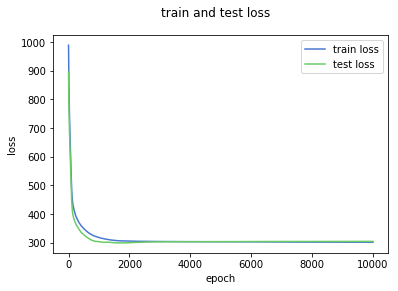

In [255]:
plt.plot([x for x in range(10000)], loss_dic['train'], label = "train loss")
plt.plot([x for x in range(10000)], loss_dic['validation'], label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.suptitle("train and test loss")
plt.legend();

In [261]:
df2 = df
X = df2[['tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr']]
X = torch.from_numpy(scaler.transform(np.array(X, dtype = 'f'))).float()
df2["predicted"] = model(X).detach().numpy()
len(df2)

1000

In [263]:
df2.sort_values(by=['predicted'])

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,rating,expression,predicted
944,117.187500,1264.981560,59.127955,2171.708422,145.563291,0.241942,0.013321,0.031199,0.025192,1038.936292,21.836195,11.000235,10,t>>(((t>>((t&(t>>2))*1))*((t+(t>>2))&4))|(t&2)),0.718669
768,93.750000,1494.409724,15.781030,3004.006197,1.708255,0.248912,0.007404,0.000012,0.000174,1435.233412,42.303317,15.317678,0,((t-(t|7))>>(((t^(t*13))>>(t|9))&9))|(((t>>6)%...,1.682481
872,117.187500,1259.010023,41.480951,2317.872135,46.546228,0.130207,0.004673,0.016849,0.004149,1148.473595,19.823362,5.806290,0,(t|1)&(((t>>1)-((t|2)+0))>>(t&2)),1.840512
784,117.187500,1590.042443,117.903620,3097.547974,65.468170,0.280076,0.032846,0.007917,0.001212,1336.462052,24.784949,7.637046,10,((t*(t>>7))*(t>>9))&(t&(t&7)),2.171087
341,187.500000,1924.272263,79.334506,3543.368537,21.723700,0.436244,0.012817,0.006357,0.006148,1444.940595,30.571063,7.632587,5,(t^(t*((t>>4)&6)))>>((t*7)&8),2.502374
492,117.187500,1707.906251,61.167099,3945.254198,11.774001,0.252877,0.007159,0.015303,0.003982,1641.205641,26.501680,9.966337,0,((t+1)&((t>>2)^(t>>1)))|(((t|3)*1)*(t%2)),2.661031
692,58.593750,1219.482093,327.322567,3097.681237,779.678068,0.281342,0.205518,0.000550,0.001466,1368.481624,54.065020,21.407121,5,(((t>>5)|4)>>(t&9))+(t>>(t*(((t>>3)*((t>>5)*2)...,2.918584
796,93.750000,614.242193,34.071408,1576.950626,97.784699,0.001460,0.000059,0.008450,0.002190,971.377923,7.019122,6.912438,0,(t^6)/(((t+5)*(t>>(t|(((t+(t>>6))>>7)^2))))|5),3.731800
217,187.500000,1449.642873,24.354715,3327.442031,49.245588,0.132039,0.003728,0.015828,0.004233,1361.659852,29.532863,12.451866,5,t&(t>>((t&(t*-1))&2)),3.874604
550,93.750000,613.583141,37.582682,1575.976146,102.981326,0.001460,0.000059,0.008484,0.002285,970.489054,6.728342,6.973683,0,t/(((t*4)&(t&4))|5),3.930269


In [21]:
for H in range(8,9):
    N, D_in, H1, H2, D_out = 500, 12, H, 2, 1 #4
    t_loss = []
    v_loss = []
    for i in range(2):
        loss_dic = {'train': [], 'validation': []}
        train_dataset, test_dataset = torch.utils.data.random_split(torch.cat((x, y), 1), [train_size, test_size])
        X_train = train_dataset.dataset[train_dataset.indices][:, :D_in]
        X_test = test_dataset.dataset[test_dataset.indices][:, :D_in]
        y_train = train_dataset.dataset[train_dataset.indices][:, D_in: D_in + D_out]
        y_test = test_dataset.dataset[test_dataset.indices][:, D_in:D_in + D_out]

        scaler = preprocessing.StandardScaler()
        X_train = torch.from_numpy(scaler.fit_transform(X_train.numpy()))
        X_test = torch.from_numpy(scaler.transform(X_test.numpy()))

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H1, H2, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H2, D_out, bias=False),
        )

        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)


        mse = torch.nn.MSELoss(reduction='sum')
        #l1 = torch.nn.L1Loss(reduction='sum')
        
        learning_rate = 1e-6
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        loss_dic['train'] = []
        loss_dic['validation'] = []
        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)
        for t in range(10000):

            y_pred = model(X_train)

            loss = mse(y_pred, y_train)
            #loss = l1(y_pred, y_train)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_validation_pred = model(X_test)

            loss_validation = mse(y_validation_pred, y_test)
            #loss_validation = l1(y_validation_pred, y_test)
            
            loss_dic['train'].append(loss / train_size)
            loss_dic['validation'].append(loss_validation / test_size)

            if t == 9999:
                t_loss.append(loss.item() / train_size)
                v_loss.append(loss_validation.item() / test_size)
                #print(t, loss.item() / train_size, loss_validation.item() / test_size)
    v_loss = np.array(v_loss)
    t_loss = np.array(t_loss)
    print("%d: Test loss: %d ~ %d, Val loss: %d ~ %d" % (H, t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

8: Test loss: 221 ~ 12, Val loss: 505 ~ 90


In [22]:
for H in range(11,13):
    N, D_in, H, D_out = 500, 12, H, 1 #4
    t_loss = []
    v_loss = []
    for i in range(5):
        loss_dic = {'train': [], 'validation': []}

        train_dataset, test_dataset = torch.utils.data.random_split(torch.cat((x, y), 1), [train_size, test_size])
        X_train = train_dataset.dataset[train_dataset.indices][:, :D_in]
        X_test = test_dataset.dataset[test_dataset.indices][:, :D_in]
        y_train = train_dataset.dataset[train_dataset.indices][:, D_in: D_in + D_out]
        y_test = test_dataset.dataset[test_dataset.indices][:, D_in:D_in + D_out]

        scaler = preprocessing.StandardScaler()
        X_train = torch.from_numpy(scaler.fit_transform(X_train.numpy()))
        X_test = torch.from_numpy(scaler.transform(X_test.numpy()))

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out, bias=False),
        )

        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)


        mse = torch.nn.MSELoss(reduction='sum')
        #l1 = torch.nn.L1Loss(reduction='sum')
        
        learning_rate = 1e-6
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        loss_dic['train'] = []
        loss_dic['validation'] = []
        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)
        for t in range(10000):

            y_pred = model(X_train)

            loss = mse(y_pred, y_train)
            #loss = l1(y_pred, y_train)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_validation_pred = model(X_test)

            loss_validation = mse(y_validation_pred, y_test)
            #loss_validation = l1(y_validation_pred, y_test)
            
            loss_dic['train'].append(loss / train_size)
            loss_dic['validation'].append(loss_validation / test_size)

            if t == 9999:
                t_loss.append(loss.item() / train_size)
                v_loss.append(loss_validation.item() / test_size)
                #print(t, loss.item() / train_size, loss_validation.item() / test_size)
    v_loss = np.array(v_loss)
    t_loss = np.array(t_loss)
    print("%d: Test loss: %d ~ %d, Val loss: %d ~ %d" % (H, t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

11: Test loss: 251 ~ 10, Val loss: 460 ~ 61
12: Test loss: 241 ~ 16, Val loss: 446 ~ 100


In [23]:
v_loss = np.array(v_loss)
t_loss = np.array(t_loss)
print("Test loss: %d ~ %d, Val loss: %d ~ %d" % (t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

Test loss: 241 ~ 16, Val loss: 446 ~ 100


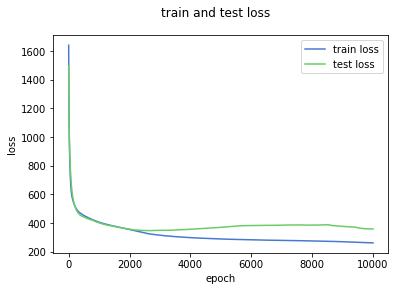

In [24]:
plt.plot([x for x in range(10000)], loss_dic['train'], label = "train loss")
plt.plot([x for x in range(10000)], loss_dic['validation'], label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.suptitle("train and test loss")
plt.legend();

In [25]:
y_validation_pred = model(X_test)

In [26]:
df2 = pd.read_csv("spectral_data2.csv")
X = df2[['tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr']]
y = df2["cont_rating"]

FileNotFoundError: File b'spectral_data2.csv' does not exist

In [ ]:
y_pred = model(torch.from_numpy(scaler.transform(np.array(X, dtype = 'f'))))

In [ ]:
y_pred.detach().numpy()

In [ ]:
df2["y_pred"] = y_pred.detach().numpy()

In [ ]:
df2.describe()


In [ ]:
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
df2.head()